# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# EDA

In [6]:
df_sample_submission = pd.read_csv('./input/playground-series-s3e7/sample_submission.csv')
df_train = pd.read_csv('./input/playground-series-s3e7/train.csv', index_col='id')
df_test = pd.read_csv('./input/playground-series-s3e7/test.csv', index_col='id')

In [7]:
df_train.isna().sum()

no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

##### There are no missing values in our data.

In [10]:
df_sample_submission.head()

,id,booking_status
0,42100,0.392
1,42101,0.392
2,42102,0.392
3,42103,0.392
4,42104,0.392


##### We are predicting the likelihood that a given booking will be cancelled.

In [11]:
df_train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
id,,,,,,,,,,,,,,,,,,
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


##### All features are numeric, however some are still categorical like room_type_reserved which should be OneHot encoded.

In [12]:
df_train.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000
mean,1.920713,0.141093,0.884632,2.398005,0.239192,0.025249,0.428931,103.888029,2017.856295,7.593539,15.902945,0.728504,0.029192,0.019715,0.175772,104.566377,0.571734,0.392019
std,0.524950,0.450128,0.885693,1.427330,0.587674,0.156884,0.832605,81.069343,0.350795,2.829395,8.888582,0.633529,0.168347,0.325837,1.732121,37.139165,0.775041,0.488207
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,37.000000,2018.000000,6.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.000000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,93.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,1.000000,155.000000,2018.000000,10.000000,24.000000,1.000000,0.000000,0.000000,0.000000,123.300000,1.000000,1.000000
max,4.000000,9.000000,7.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,540.000000,5.000000,1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

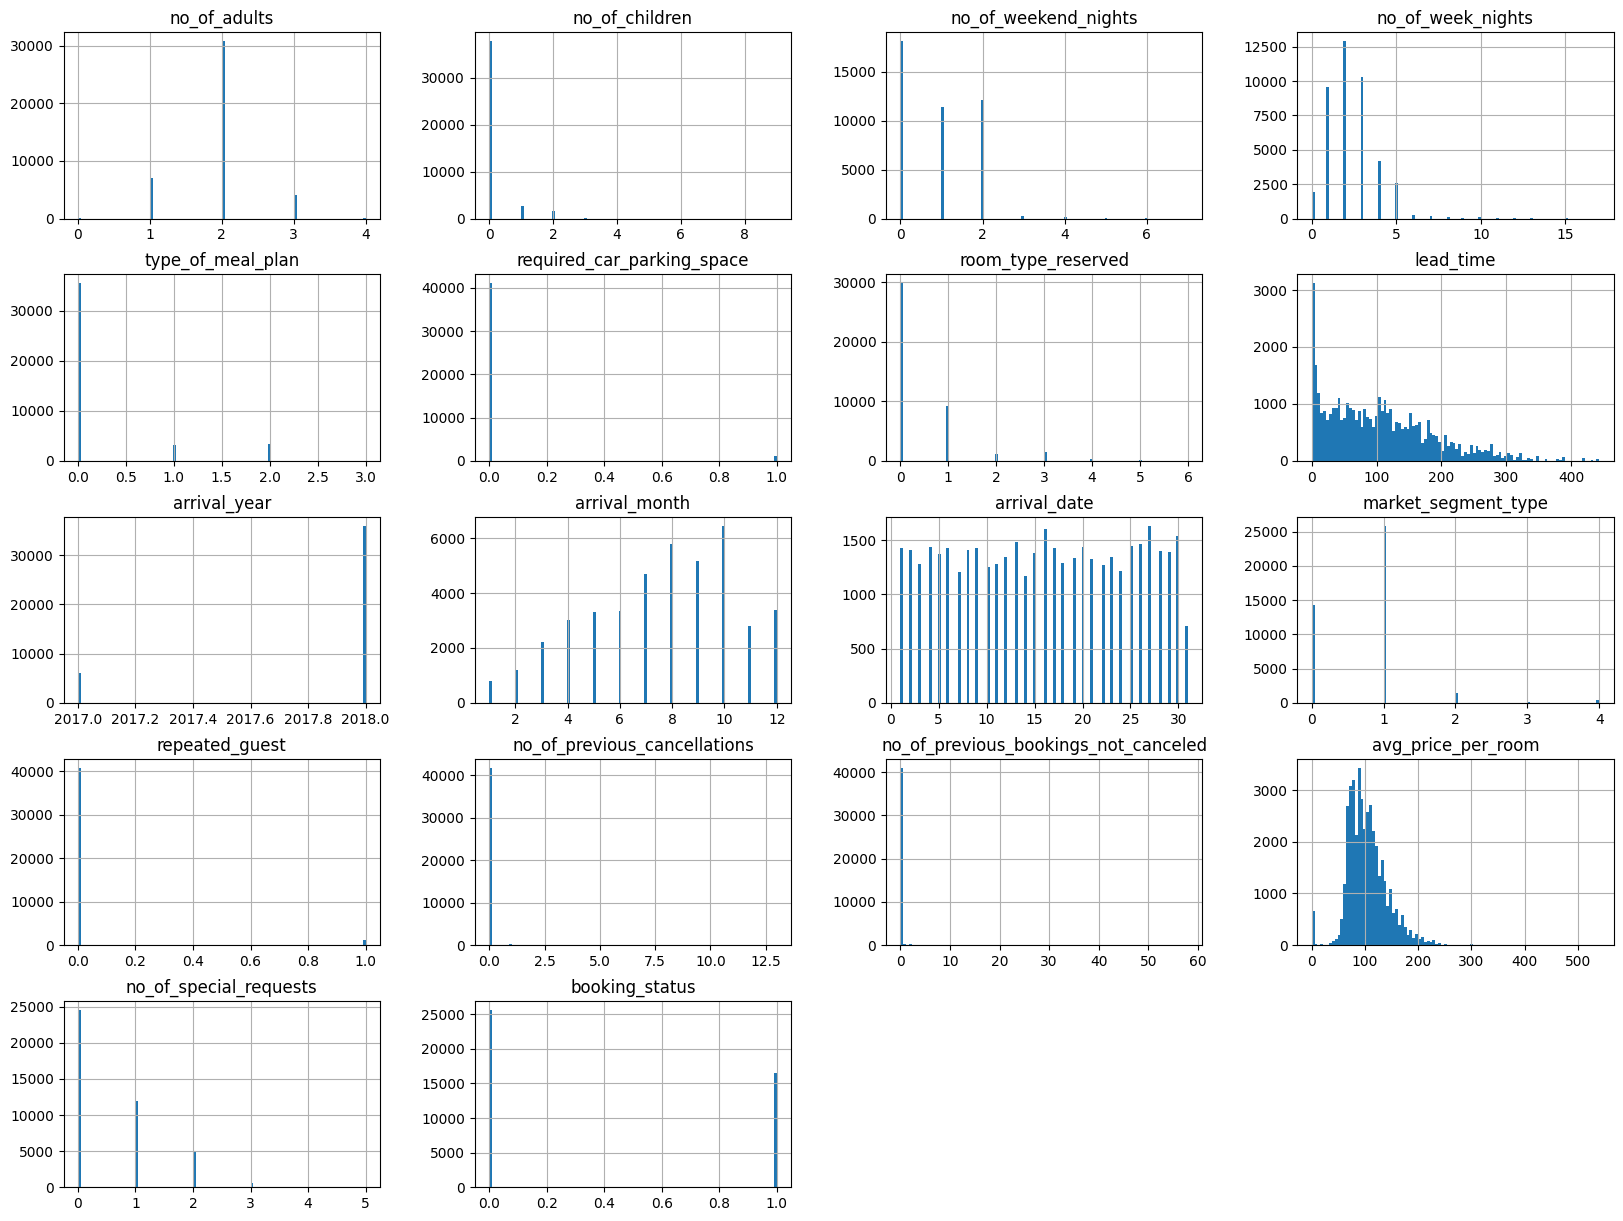

In [13]:
df_train.hist(bins=100, figsize=(20, 15))
plt.show

##### It appears that there are some outliers but from data context we can deduce that they are true outliers, some rooms will very expensive in the true population however they may not be representative of the underlying population, we may benefit from removing them.

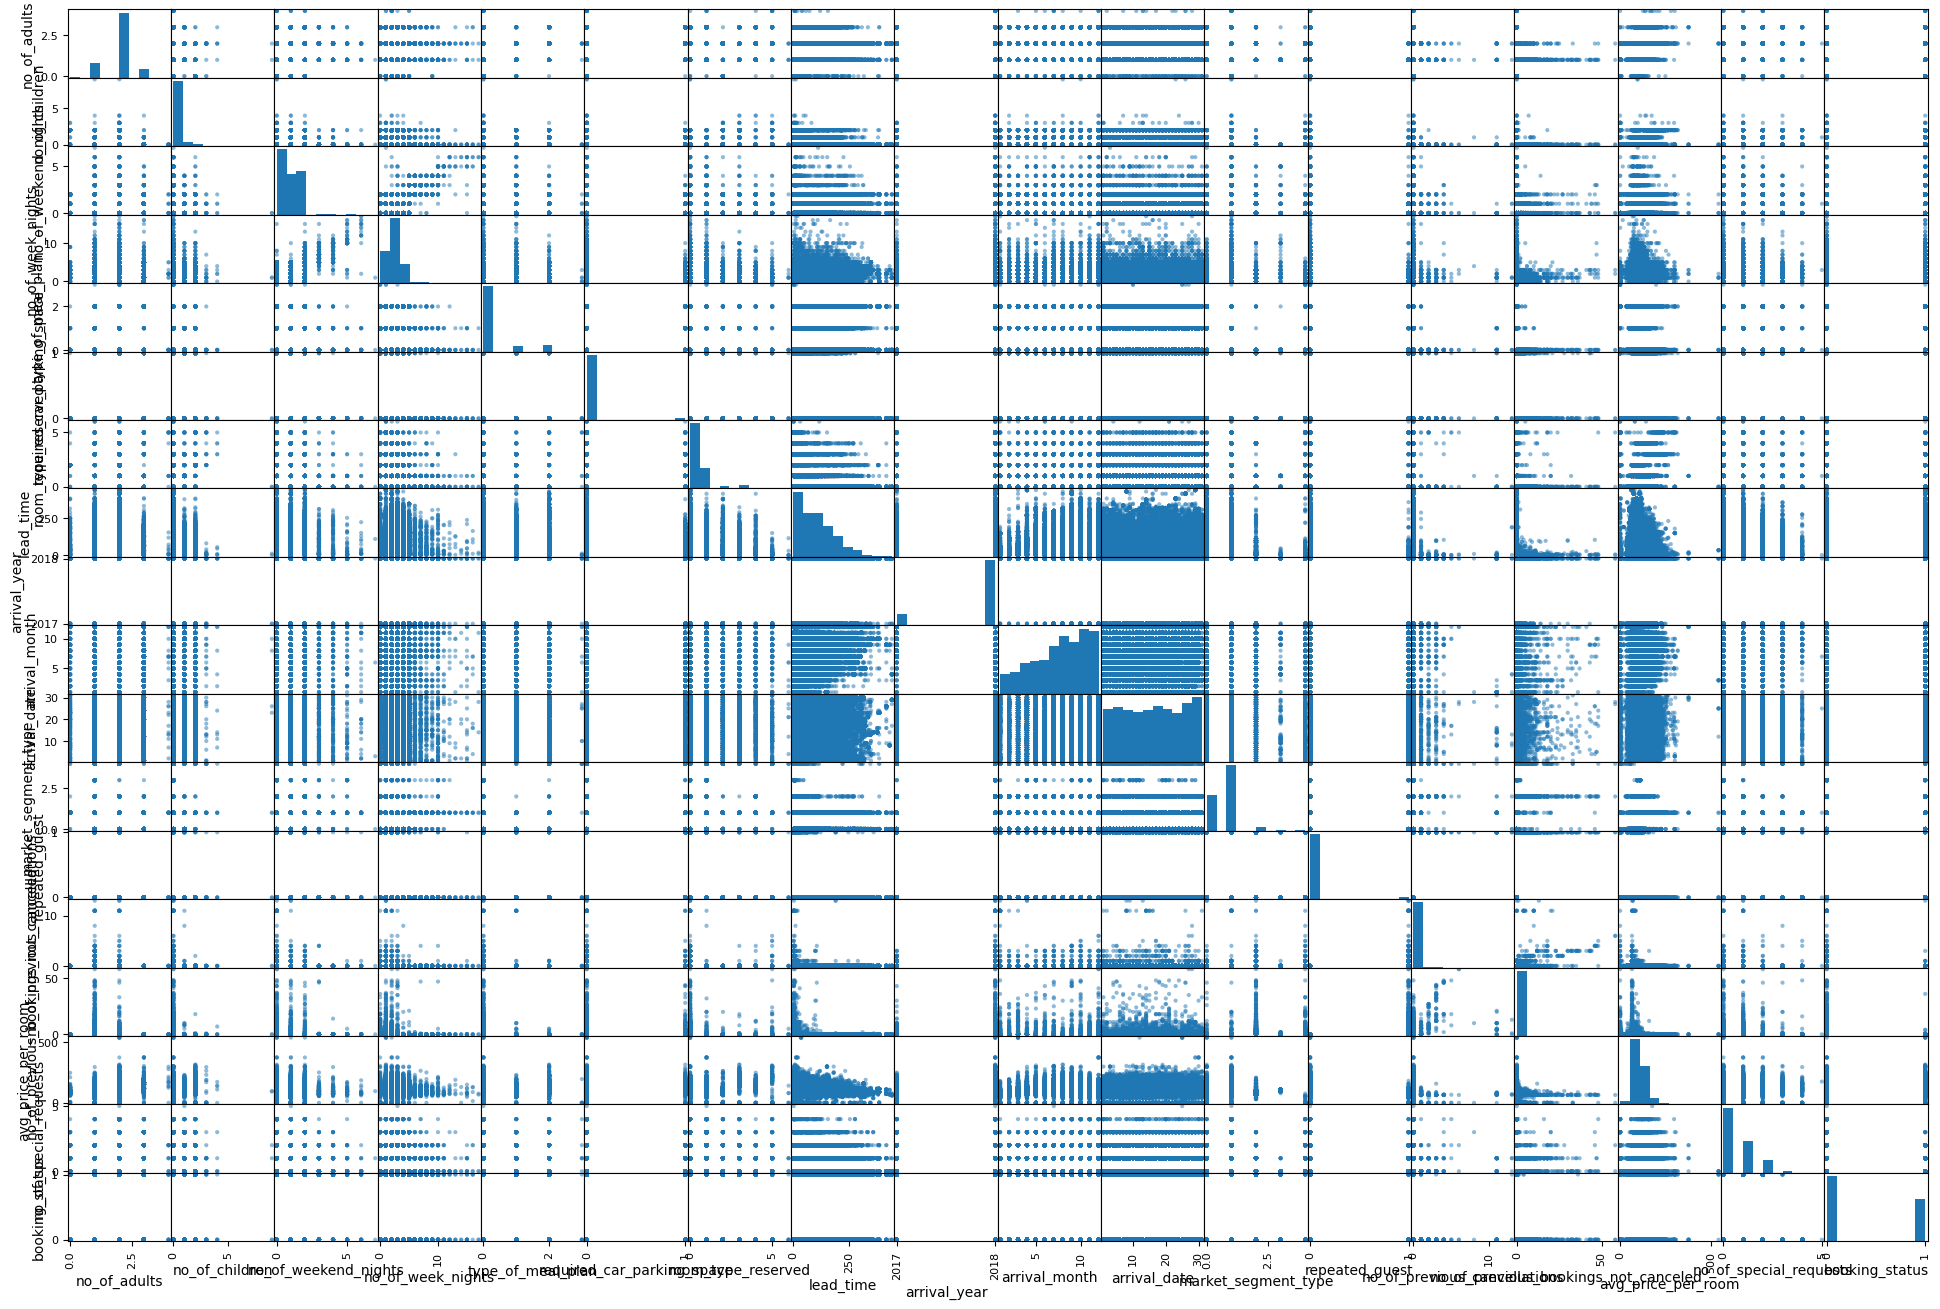

In [14]:
pd.plotting.scatter_matrix(df_train, figsize=(24, 16))
plt.savefig(r"figure_1.png")
plt.show()

# Data Pipeline

# Hyperparameter search

# Train the model

# Feature Importance

# Make Submission